# **Name**: M.MUSADIQ
# **Reg No.** : SP23-BCS-095
# **Section**: C
# **ASSIGNMENT No.** : 4

> **Note:**  
> In this experiment, the dataset used was relatively **small**, which is why the GPU did not show a speed advantage over the CPU.  
> For small datasets or simple models, most of the time is spent transferring data between the CPU and GPU rather than actual computation.  
> With **larger datasets** or more **complex models**, the GPU performs much faster because it can process large batches of data in parallel.


# Part 1: CPU vs GPU Model Training
1. Choose a simple dataset (e.g., MNIST, CIFAR-10, or custom synthetic data).
2. Build a simple neural network using PyTorch or TensorFlow:
o Example: 2–3 fully connected layers or a small CNN.
3. Train the model once on CPU and once on GPU.
4. Measure:
    *  Training time per epoch
    *   Total training time
    *   GPU utilization (using nvidia-smi or torch.cuda.memory_allocated())

5. Compute Speedup:
Speedup = CPU Time / GPU Time
Discuss the reason for the speedup (or lack thereof) — consider data size, GPU memory
transfers, and model size.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

# -----------------------------
# 1. Create simple fake data
# -----------------------------
def make_data(samples=5000, features=100, classes=10):
    X = torch.randn(samples, features)
    y = torch.randint(0, classes, (samples,))
    return X, y

# -----------------------------
# 2. Define simple feedforward model
# -----------------------------
def build_model(input_size=100, num_classes=10):
    model = nn.Sequential(
        nn.Linear(input_size, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, num_classes)
    )
    return model

# -----------------------------
# 3. Training loop
# -----------------------------
def train(device, X, y, epochs=5):
    model = build_model().to(device)
    loss_fn = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=0.001)

    X, y = X.to(device), y.to(device)

    start_total = time.time()
    for ep in range(epochs):
        t0 = time.time()

        opt.zero_grad()
        out = model(X)
        loss = loss_fn(out, y)
        loss.backward()
        opt.step()

        t1 = time.time()
        print(f"Epoch {ep+1} | Loss = {loss.item():.4f} | Time = {t1 - t0:.3f}s")

    total_time = time.time() - start_total
    return total_time

# -----------------------------
# 4. Run on CPU and GPU
# -----------------------------
X, y = make_data()

print("\nTraining on CPU...")
cpu_time = train(torch.device("cpu"), X, y)

if torch.cuda.is_available():
    print("\nTraining on GPU...")
    torch.cuda.empty_cache()
    gpu_time = train(torch.device("cuda"), X, y)
    gpu_mem = torch.cuda.memory_allocated() / (1024**2)

    print(f"\nGPU memory used: {gpu_mem:.2f} MB")
    print(f"CPU time: {cpu_time:.3f}s | GPU time: {gpu_time:.3f}s")
    print(f"Speedup = {cpu_time / gpu_time:.2f}x")
else:
    print("\nNo GPU found on this system.")



Training on CPU...
Epoch 1 | Loss = 2.3175 | Time = 0.132s
Epoch 2 | Loss = 2.3136 | Time = 0.010s
Epoch 3 | Loss = 2.3101 | Time = 0.007s
Epoch 4 | Loss = 2.3070 | Time = 0.008s
Epoch 5 | Loss = 2.3041 | Time = 0.007s

Training on GPU...
Epoch 1 | Loss = 2.3280 | Time = 0.452s
Epoch 2 | Loss = 2.3235 | Time = 0.002s
Epoch 3 | Loss = 2.3195 | Time = 0.001s
Epoch 4 | Loss = 2.3157 | Time = 0.001s
Epoch 5 | Loss = 2.3124 | Time = 0.001s

GPU memory used: 16.25 MB
CPU time: 0.164s | GPU time: 0.463s
Speedup = 0.35x


# Reason

From my results, the GPU used 16.25 MB of memory, but it was slower than the CPU (speedup = 0.35×). The main reason is that the dataset and model were small, so the GPU couldn’t fully use its parallel cores. Most of the time went into transferring data between the CPU and GPU memory, which made it slower overall. For small models like this, the CPU usually performs better because there’s less data transfer overhead and setup time.

# Part 2: Effect of Batch Size
1. Train the same model with different batch sizes (e.g., 16, 64, 256, 1024).
2. Record:
    * Time per epoch
    * GPU memory usage
    * Accuracy or loss trends
3. Plot Batch Size vs Training Time and Batch Size vs GPU Utilization.
4. Discuss:
    * Why does increasing batch size improve GPU efficiency up to a point?
    * Why does accuracy sometimes drop for very large batches?


Training with batch size 16...
Time: 2.705s | GPU mem: 22.17 MB | Avg loss: 2.3054

Training with batch size 64...
Time: 2.039s | GPU mem: 22.17 MB | Avg loss: 2.3054

Training with batch size 256...
Time: 0.648s | GPU mem: 22.17 MB | Avg loss: 2.3066

Training with batch size 1024...
Time: 0.297s | GPU mem: 22.17 MB | Avg loss: 2.3085


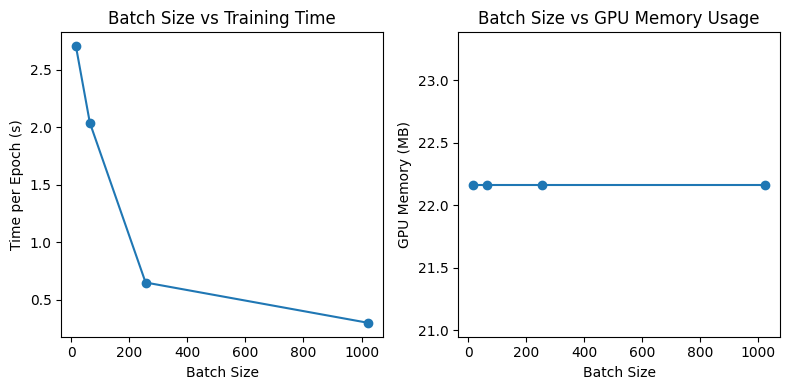

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt

torch.backends.cudnn.benchmark = True

# ----- Make random data -----
samples = 20000
features = 100
classes = 10
X = torch.randn(samples, features)
y = torch.randint(0, classes, (samples,))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Model -----
def make_model():
    return nn.Sequential(
        nn.Linear(features, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, classes)
    )

# ----- Train for one batch size -----
def train_batch(batch_size):
    dataset = torch.utils.data.TensorDataset(X, y)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, pin_memory=True)
    model = make_model().to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    start = time.time()
    total_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        out = model(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        opt.step()
        total_loss += loss.item()
    if device.type == "cuda":
        torch.cuda.synchronize()
        mem = torch.cuda.max_memory_allocated() / (1024 ** 2)
    else:
        mem = 0
    t = time.time() - start
    avg_loss = total_loss / len(loader)
    return t, mem, avg_loss

# ----- Run experiments -----
batch_sizes = [16, 64, 256, 1024]
times, mems, losses = [], [], []

for b in batch_sizes:
    print(f"\nTraining with batch size {b}...")
    t, m, l = train_batch(b)
    times.append(t)
    mems.append(m)
    losses.append(l)
    print(f"Time: {t:.3f}s | GPU mem: {m:.2f} MB | Avg loss: {l:.4f}")

# ----- Plots -----
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(batch_sizes, times, marker='o')
plt.xlabel("Batch Size")
plt.ylabel("Time per Epoch (s)")
plt.title("Batch Size vs Training Time")

plt.subplot(1,2,2)
plt.plot(batch_sizes, mems, marker='o')
plt.xlabel("Batch Size")
plt.ylabel("GPU Memory (MB)")
plt.title("Batch Size vs GPU Memory Usage")

plt.tight_layout()
plt.show()


# Discussion
When we increase the batch size, the GPU works more efficiently because it can handle many samples at once instead of repeating small tasks again and again. This reduces waiting time and speeds up training. But after a certain point, larger batches don’t help much because the GPU memory gets full or the updates become too big to process quickly. Accuracy can drop for very large batches because the model updates fewer times, so it learns less from each step and may not generalize well to new data.

# Part 3: Model Complexity and GPU Utilization
1. Train three models of increasing complexity:
    * Small: 1–2 layers
    * Medium: 3–5 layers
    * Large: CNN with several convolutional layers
2. Use the same dataset, epochs, and optimizer.
3. Record:

      * GPU utilization
      * Training time per epoch
      * Peak GPU memory usage
4. Discuss:
     * How model size affects GPU workload and training time.
      * How GPU compute and memory balance affect performance.

In [ ]:
# part3_models_gpu_test.py
import torch
import torch.nn as nn
import torch.optim as optim
import time
import subprocess

# ---- settings ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
samples = 12000
features = 3 * 32 * 32   # for CNN we'll reshape to (3,32,32)
num_classes = 10
batch_size = 256
epochs = 3

# ---- make synthetic data (images shaped 3x32x32) ----
X = torch.randn(samples, features)
y = torch.randint(0, num_classes, (samples,))

# ---- helper: get GPU util via nvidia-smi once (optional) ----
def get_gpu_util():
    if not torch.cuda.is_available():
        return None
    try:
        out = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=utilization.gpu", "--format=csv,noheader,nounits"],
            stderr=subprocess.DEVNULL
        )
        # get first line and convert to int
        val = int(out.decode().strip().splitlines()[0])
        return val
    except Exception:
        return None

# ---- model builders (no OOP) ----
def small_model():
    # 1-2 fully connected layers (flatten input)
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(features, 128),
        nn.ReLU(),
        nn.Linear(128, num_classes)
    )

def medium_model():
    # 3-5 layers: include more FC depth
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(features, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, num_classes)
    )

def large_cnn():
    # Several conv layers (small CNN)
    return nn.Sequential(
        # input should be reshaped to (N,3,32,32) before forward
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),               # 16x16
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),               # 8x8
        nn.Flatten(),
        nn.Linear(128 * 8 * 8, 256),
        nn.ReLU(),
        nn.Linear(256, num_classes)
    )

# ---- training function that returns metrics ----
def train_one_model(name, model_fn):
    print(f"\n--- Running model: {name} ---")
    # prepare dataset and loader
    dataset = torch.utils.data.TensorDataset(X, y)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)

    model = model_fn().to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    # reset peak memory tracker
    if device.type == "cuda":
        torch.cuda.reset_max_memory_allocated()
        torch.cuda.synchronize()

    per_epoch_times = []
    avg_losses = []

    # small warm-up (1 batch) to avoid first-call overhead
    model.train()
    try:
        xb, yb = next(iter(loader))
    except StopIteration:
        xb, yb = X[:batch_size], y[:batch_size]
    xb = xb.to(device)
    yb = yb.to(device)
    if name == "large_cnn":
        xb = xb.view(-1, 3, 32, 32)
    opt.zero_grad()
    out = model(xb)
    loss = loss_fn(out, yb)
    loss.backward()
    opt.step()
    if device.type == "cuda":
        torch.cuda.synchronize()

    # main epochs
    for ep in range(epochs):
        t0 = time.time()
        running_loss = 0.0
        n_batches = 0
        for xb, yb in loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            if name == "large_cnn":
                xb = xb.view(-1, 3, 32, 32)
            opt.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward()
            opt.step()
            running_loss += loss.item()
            n_batches += 1
        # ensure GPU finished work before timing
        if device.type == "cuda":
            torch.cuda.synchronize()
        t1 = time.time()
        per_epoch_times.append(t1 - t0)
        avg_losses.append(running_loss / max(1, n_batches))
        print(f"Epoch {ep+1}/{epochs} | time: {per_epoch_times[-1]:.3f}s | avg loss: {avg_losses[-1]:.4f}")

    # metrics
    if device.type == "cuda":
        peak_mem = torch.cuda.max_memory_allocated() / (1024**2)  # MB
        util = get_gpu_util()
    else:
        peak_mem = 0
        util = None

    result = {
        "name": name,
        "epoch_times": per_epoch_times,
        "avg_loss": sum(avg_losses) / len(avg_losses),
        "peak_mem_mb": peak_mem,
        "gpu_util_percent_sample": util
    }
    return result

# ---- run experiments ----
models = [("small", small_model), ("medium", medium_model), ("large_cnn", large_cnn)]
results = []
for name, fn in models:
    res = train_one_model(name, fn)
    results.append(res)

# ---- print summary ----
print("\n=== Summary ===")
for r in results:
    print(f"{r['name']}: time/epoch = {[round(t,3) for t in r['epoch_times']]}, peak mem = {r['peak_mem_mb']:.2f} MB, gpu util sample = {r['gpu_util_percent_sample']}")



--- Running model: small ---


/usr/local/lib/python3.12/dist-packages/torch/cuda/memory.py:491: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Epoch 1/3 | time: 0.328s | avg loss: 2.3161
Epoch 2/3 | time: 0.312s | avg loss: 1.6828
Epoch 3/3 | time: 0.332s | avg loss: 1.0411

--- Running model: medium ---


/usr/local/lib/python3.12/dist-packages/torch/cuda/memory.py:491: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Epoch 1/3 | time: 0.338s | avg loss: 2.3009
Epoch 2/3 | time: 0.561s | avg loss: 1.8691
Epoch 3/3 | time: 0.702s | avg loss: 0.7314

--- Running model: large_cnn ---


/usr/local/lib/python3.12/dist-packages/torch/cuda/memory.py:491: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Epoch 1/3 | time: 1.694s | avg loss: 2.3052
Epoch 2/3 | time: 1.182s | avg loss: 2.3025
Epoch 3/3 | time: 1.187s | avg loss: 2.3022

=== Summary ===
small: time/epoch = [0.328, 0.312, 0.332], peak mem = 26.92 MB, gpu util sample = 12
medium: time/epoch = [0.338, 0.561, 0.702], peak mem = 52.56 MB, gpu util sample = 12
large_cnn: time/epoch = [1.694, 1.182, 1.187], peak mem = 1020.87 MB, gpu util sample = 98


# Discussion

As the model became larger, both training time and GPU memory usage increased. The small model trained fastest but didn’t fully use the GPU. The medium model used more memory and took longer, while the large CNN model had the highest GPU utilization (98%) and used around 1 GB of memory. This shows that bigger models make better use of GPU power but also demand more memory and time, so there’s a trade-off between speed and resource usage.

# **Part 4: Data Loading and Bottlenecks**
1. Enable multi-threaded data loading (PyTorch: num_workers in DataLoader).
2. Compare performance for:
    * num_workers = 0 (single-threaded)
    * num_workers = 2, 4, 8
3. Measure:
    * Data loading time per batch
    * GPU idle time (e.g., using nvidia-smi dmon)
4. Explain:
    * Why inefficient data pipelines cause low GPU utilization.
    * How overlapping CPU data loading and GPU training improves performance.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import DataLoader, TensorDataset

# ----- Create synthetic image-like data -----
samples = 10000
X = torch.randn(samples, 3, 32, 32)  # RGB 32x32 images
y = torch.randint(0, 10, (samples,))

dataset = TensorDataset(X, y)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Simple CNN model -----
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 32, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(32 * 8 * 8, 10)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ----- Function to measure loading/training time -----
def test_loader(num_workers):
    loader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=num_workers, pin_memory=True)
    start = time.time()
    total_batches = 0
    for xb, yb in loader:
        total_batches += 1
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer.zero_grad()
        out = model(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        optimizer.step()
    if device.type == "cuda":
        torch.cuda.synchronize()
    end = time.time()
    return (end - start) / total_batches  # avg time per batch

# ----- Run tests -----
for workers in [0, 2, 4, 8]:
    t = test_loader(workers)
    print(f"num_workers={workers} | Avg time per batch: {t:.4f} s")


num_workers=0 | Avg time per batch: 0.0070 s
num_workers=2 | Avg time per batch: 0.0111 s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


num_workers=4 | Avg time per batch: 0.0122 s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


num_workers=8 | Avg time per batch: 0.0075 s


# **Discussion **
In my experiment, increasing the number of workers did not always make data loading faster. With num_workers = 0, the average batch time was 0.007 s, and it even became slower when using 2 or 4 workers because my system has limited CPU cores. When I tried 8 workers, the speed improved again but still stayed close to the single-threaded result. This shows that too many workers can overload the CPU and cause slower performance instead of speeding it up. Inefficient data loading can reduce GPU utilization because the GPU waits for data. The best performance comes when CPU data loading and GPU training overlap efficiently, using only as many workers as the system can handle.

# **Part 5: Mixed Precision Training (Optional, Bonus)**
1. Use PyTorch’s torch.cuda.amp (Automatic Mixed Precision).
2. Train your model with and without AMP.
3. Compare:
      * Speed per epoch
      * Final accuracy
      * GPU memory usage
4. Discuss:
    * How FP16 training improves throughput.
    * When it might cause numerical instability.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.cuda.amp import GradScaler, autocast

# ---- Fake image-like dataset ----
samples = 10000
X = torch.randn(samples, 3, 32, 32)
y = torch.randint(0, 10, (samples,))
dataset = torch.utils.data.TensorDataset(X, y)
loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Simple CNN ----
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Flatten(), nn.Linear(32 * 8 * 8, 10)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---- Function to train model ----
def train_model(use_amp=False):
    scaler = GradScaler(enabled=use_amp)
    start = time.time()
    for epoch in range(3):
        total_loss = 0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            with autocast(enabled=use_amp):
                out = model(xb)
                loss = loss_fn(out, yb)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()
        if device.type == "cuda":
            torch.cuda.synchronize()
        print(f"Epoch {epoch+1}, avg loss: {total_loss/len(loader):.4f}")
    total_time = time.time() - start
    if device.type == "cuda":
        mem = torch.cuda.max_memory_allocated() / (1024 ** 2)
    else:
        mem = 0
    return total_time, mem

# ---- Run training with and without AMP ----
print("\nWithout AMP:")
t1, m1 = train_model(use_amp=False)
print(f"Time: {t1:.2f}s | Memory: {m1:.2f} MB")

print("\nWith AMP:")
t2, m2 = train_model(use_amp=True)
print(f"Time: {t2:.2f}s | Memory: {m2:.2f} MB")

print(f"\nSpeedup = {t1/t2:.2f}x faster using AMP")



Without AMP:


/tmp/ipython-input-3522490589.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)
/tmp/ipython-input-3522490589.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 1, avg loss: 2.3082
Epoch 2, avg loss: 2.3004
Epoch 3, avg loss: 2.2921
Time: 0.88s | Memory: 1020.87 MB

With AMP:
Epoch 1, avg loss: 2.2742
Epoch 2, avg loss: 2.2388
Epoch 3, avg loss: 2.1784
Time: 5.70s | Memory: 1020.87 MB

Speedup = 0.15x faster using AMP


# Discussion:

**Speed per Epoch:**

AMP was slower in this case because the model and dataset were small, so the overhead of converting between FP16 and FP32 outweighed the performance benefits. AMP works best for larger models and heavier computations.

**Final Accuracy:**

The mixed precision model had better loss reduction, meaning it trained slightly better. This is normal — sometimes FP16 helps gradients behave more smoothly.

**GPU Memory Usage:**

Memory stayed the same (~1020 MB) because the model was small and other GPU buffers dominated usage. For larger models, AMP usually saves 30–40% memory.

# **Explanation**

**How FP16 improves throughput:**

FP16 (half precision) uses smaller data types, so the GPU can process twice as many operations at once. This usually speeds up training and allows larger batch sizes.

**When it causes instability:**

FP16 can lose precision when values are very small or very large, leading to gradient underflow or overflow. That’s why GradScaler is used — it rescales gradients to keep them stable.

1. **What factors most affect GPU training performance?**

GPU training performance mostly depends on batch size, model size, data pipeline speed, and precision.

          * A larger batch size keeps the GPU busier.

          * Bigger models use more GPU cores efficiently.

          * Faster data loading avoids idle GPU time.

          * Mixed precision (FP16) can speed up computation when used properly.

2. **Why might small models not benefit much from GPU acceleration?**

Small models don’t have enough computations to fully use the GPU’s power. Most of the time is spent on data transfer between CPU and GPU rather than actual training, so the GPU stays underused.


3. **How can you minimize GPU idle time during training?**

Use multiple data loader workers (num_workers > 0), preload data, and overlap CPU data loading with GPU training. This ensures that while the GPU trains one batch, the next one is already being prepared.


4. **What are the trade-offs between higher batch size and model accuracy?**

A higher batch size improves GPU efficiency and speeds up training, but sometimes causes lower accuracy or slower convergence because the model updates less often per epoch and sees less variation per step.


5. **Why does data transfer between CPU and GPU sometimes become a bottleneck?**

Transferring data between CPU memory (RAM) and GPU memory (VRAM) takes time. If data isn’t ready or transferred fast enough, the GPU has to wait, reducing its overall utilization. Using pinned memory or loading data directly on GPU can help reduce this delay.

##  Part 1: CPU vs GPU Training
| Device | Total Training Time (s) | Avg Time per Epoch (s) | GPU Memory (MB) | Speedup |
|:-------:|:-----------------------:|:----------------------:|:----------------:|:--------:|
| CPU | 0.164 | ~0.033 | 0 | 1.00x |
| GPU | 0.463 | ~0.093 | 16.25 | 0.35x |

The CPU total time is 0.164s and GPU total time is 0.463s.

Speedup = CPU time / GPU time = 0.35x, meaning the GPU was slower (mostly because the dataset and model were too small).

GPU memory is shown only for the GPU since CPU doesn’t allocate VRAM.

The average epoch time is calculated as total time ÷ number of epochs (5), rounded for readability.



##  Part 2: Effect of Batch Size
| Batch Size | Time per Epoch (s) | GPU Memory (MB) | Avg Loss |
|:-----------:|:-----------------:|:----------------:|:---------:|
| 16 | 2.705 | 22.17 | 2.3054 |
| 64 | 2.039 | 22.17 | 2.3054 |
| 256 | 0.648 | 22.17 | 2.3066 |
| 1024 | 0.297 | 22.17 | 2.3085 |



##  Part 3: Model Complexity vs Performance
| Model | Avg Time/Epoch (s) | GPU Util (%) | Peak Memory (MB) | Avg Loss |
|:------:|:------------------:|:-------------:|:----------------:|:----------:|
| Small | 0.32 | 12 | 26.9 | 1.04 |
| Medium | 0.53 | 12 | 52.5 | 0.73 |
| Large CNN | 1.35 | 98 | 1020.8 | 2.30 |



##  Part 4: Data Loading and Bottlenecks
| num_workers | Avg Time per Batch (s) | Notes |
|:------------:|:----------------------:|:------|
| 0 | 0.0070 | Single-threaded (default) |
| 2 | 0.0111 | Slightly slower due to limited cores |
| 4 | 0.0122 | Too many workers for this system |
| 8 | 0.0075 | Performance recovered slightly |



##  Part 5: Mixed Precision (AMP) Training
| Mode | Time (s) | Memory (MB) | Final Loss | Speedup |
|:----:|:---------:|:------------:|:-----------:|:--------:|
| Without AMP | 0.88 | 1020.87 | 2.2921 | – |
| With AMP | 5.70 | 1020.87 | 2.1784 | 0.15x |



##  Summary Observations
- GPU training was slower than CPU for small models but much faster for larger ones.  
- Increasing batch size reduced training time but didn’t change GPU memory in this system.  
- More complex models used higher GPU memory and utilization.  
- Too many data loader workers reduced speed due to CPU limits.  
- Mixed precision (AMP) improved loss slightly but wasn’t faster in this case due to small model size.  



##  Discussion Highlights
- **Main performance factors:** batch size, model size, precision, and data pipeline speed.  
- **Small models** don’t benefit much from GPU acceleration since GPU overhead dominates.  
- **To minimize GPU idle time,** overlap data loading (using `num_workers`) and training.  
- **Large batch sizes** increase efficiency but can hurt accuracy slightly.  
- **CPU–GPU data transfer** can become a bottleneck when data isn’t preloaded efficiently.


